## Introduction

Because our random forest model performed well in the last notebook, in this notebook, we will try to improve the effect of the random forest model, generate and train the features of sign language data, and analyze the features' importances, and also the possible ablation experiments.

### Import packages

In [1]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# our own pipeline
from pipelines.tools import power_band, generate_feature_dict
from pipelines.data_prapare import read_power_band_txt,read_features_table, read_signal_data
from pipelines.ml_functions import prepare_signals,set_seed, clean_all_feature_table
from pipelines.ml_functions import  print_performance, evaluate_model, model_evaluation_dict

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

In [3]:
import warnings
warnings.filterwarnings("ignore")

set_seed(42)

Define a confusion matrix class:

In [4]:
from sklearn.metrics import ConfusionMatrixDisplay
from prettytable import PrettyTable
import joblib

class ConfusionMatrix(object):
    
    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.labels = labels

    def update(self, preds, labels):
        for p, t in zip(preds, labels):
            self.matrix[p-1, t-1] += 1

    def summary(self):
        # calculate accuracy
        sum_TP = 0
        n = np.sum(self.matrix)
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]
        acc = sum_TP / n
        print("the model accuracy is ", acc)

        # kappa
        sum_po = 0
        sum_pe = 0
        for i in range(len(self.matrix[0])):
            sum_po += self.matrix[i][i]
            row = np.sum(self.matrix[i, :])
            col = np.sum(self.matrix[:, i])
            sum_pe += row * col
        po = sum_po / n
        pe = sum_pe / (n * n)
        # print(po, pe)
        kappa = round((po - pe) / (1 - pe), 3)
        #print("the model kappa is ", kappa)
        
        # precision, recall, specificity
        table = PrettyTable()
        table.field_names = ["", "Precision", "Recall", "Specificity","F1score"]
        for i in range(self.num_classes):
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN

            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
            F1score = round(2*Precision*Recall/(Precision+Recall)) if Precision+Recall != 0 else 0.

            table.add_row([self.labels[i], Precision, Recall, Specificity, F1score])
            
        print(table)
        return str(acc)

    def plot(self):
        matrix = self.matrix
        print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        plt.xticks(range(self.num_classes), self.labels, rotation=45)
        plt.yticks(range(self.num_classes), self.labels)
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix (acc='+self.summary()+')')


        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()

redefine our model function, in the last notebook, we could find some models are not good enough, so we will pass it:

In [5]:
def init_classifiers():
    """
    Initialize our machine learning classifier ---
    where catboost and NN (neural network classification) are not initialized,
    and most hyperparameters will take default values

    """

    model_names = ['SVM', 'LR', 'KNN', 'GBDT', 'DT', 'AdaB', 'RF', 'XGB', 'LGB', 'Catboost', 'NN']

    # the training parameters of each model
    param_grid_svc = [{}]
    param_grid_logistic = [{'C': [0.1], 'penalty': ['l1', 'l2']}]
    param_grid_knn = [{}, {'n_neighbors': list(range(3, 8))}]
    param_grid_gbdt = [{}]
    param_grid_tree = [{}]
    param_grid_boost = [{}]
    param_grid_rf = [{}]

    return ([(SVC(), model_names[0], param_grid_svc),
             (LogisticRegression(), model_names[1], param_grid_logistic),
             (KNeighborsClassifier(), model_names[2], param_grid_knn),
             (DecisionTreeClassifier(), model_names[4], param_grid_tree),
             (RandomForestClassifier(), model_names[6], param_grid_rf)])

In [10]:
def init_classifiers_2():
    """
    Initialize our machine learning classifier ---
    where catboost and NN (neural network classification) are not initialized,
    and most hyperparameters will take default values

    """

    model_names = ['SVM', 'LR', 'KNN', 'GBDT', 'DT', 'AdaB', 'RF', 'XGB', 'LGB', 'Catboost', 'NN']

    # the training parameters of each model
    param_grid_svc = [{}]
    param_grid_logistic = [{'C': [0.1], 'penalty': ['l1', 'l2']}]
    param_grid_knn = [{}, {'n_neighbors': list(range(3, 8))}]
    param_grid_gbdt = [{}]
    param_grid_tree = [{}]
    param_grid_boost = [{}]
    param_grid_rf = [{}]

    return ([(DecisionTreeClassifier(), model_names[4], param_grid_tree),
             (RandomForestClassifier(), model_names[6], param_grid_rf)])

In [6]:
def threshold_list(alist, threshold= 0.1):
    big_thres = [i for i in alist if i >= threshold]
    small_thres = [i for i in alist if i < threshold]
    return big_thres, small_thres

### Generate ASL features

generate new seg ASL signal features:

Here we can't find the intersection of the useless features of the four major categories(asl/aat), because we have already dealt with the part of the alphabet before, so here we directly make the features of sign language consistent with those of the alphabet:

When we store the new data, rewrite the two functions read__seg_features_table and read__seg_features_table, and reload notebook:

## Models

### Performances

We have already got our alphabet vision+imagination model performance tables, so we test the following data for our 26 labels classification:

* ASL vision + imagination
* Alphabet vision + ASL vision
* Alphabet imagination + ASL imagination
* All joint data 

In [7]:
from pipelines.data_prapare import read_seg_power_band_txt,read_seg_features_table, read_seg_signal_data

aat_vis, aat_img, asl_vis, asl_img = read_seg_features_table()
col_name = list(aat_vis.columns)[1:]

# 26 * 32 * 4 
labels_1 = np.array(aat_vis['label_index'])
# 26 * 32 * 4 * 2
labels_2 = np.concatenate((labels_1, labels_1), axis=0)

# 26 * 32 * 4 * = 1664 data
labels_4 = np.concatenate((labels_2, labels_2), axis=0)

In [8]:
aat_vis.head()

,label_index,ch1_min,ch1_max,ch1_std,ch1_mean,ch1_coefficient_variation,ch1_mean_abs,ch1_AAC,ch1_CARD,ch1_EMAV,...,ch7_coherence,ch8_coherence,ch9_coherence,ch10_coherence,ch11_coherence,ch12_coherence,ch13_coherence,ch14_coherence,ch15_coherence,ch16_coherence
0,9,-3411.345591,-3267.690929,39.973104,-3321.731487,-0.012034,3321.731487,7.337829,87.0,0.711909,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,9,-3396.168756,-3262.952359,36.134852,-3307.664044,-0.010925,3307.664044,6.948661,87.0,0.731369,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,9,-3334.701459,-3273.055348,15.721139,-3296.744223,-0.004769,3296.744223,6.659578,86.0,0.718037,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,9,-3355.086250,-3291.450833,13.557959,-3328.284770,-0.004074,3328.284770,6.854287,88.0,0.556586,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,6,-3448.650652,-3338.478904,19.164575,-3367.486004,-0.005691,3367.486004,8.186451,86.0,0.815650,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


PS: In the previous notebook, I didn't start from 1 instead of 2, but there won't be a lot of problems.

In [9]:
# read and clean data
aat_vis = clean_all_feature_table(aat_vis.iloc[:, 1:])
aat_img = clean_all_feature_table(aat_img.iloc[:, 1:])
asl_vis = clean_all_feature_table(asl_vis.iloc[:, 1:])
asl_img = clean_all_feature_table(asl_img.iloc[:, 1:])

#### ASL vision + imagination

Check ASL (vis+img) 26 labels classification:

(And I won't test one mode data (i.e. ASL vision) separately here, the following model part will all be joint data, at least two mode data combination)

In [7]:
data_all = np.concatenate((asl_img, asl_vis), axis=0) 

res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_all, labels_2, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

,Classifier,param,Traing score,Test Score,Whole score,CV Score,Precision(Macro),Precision(Micro),Recall(Macro),Recall(Micro),F1 Score(Macro),F1 Score(Micro)
0,SVM,default,0.158832,0.095143,0.139724,0.091869,0.087374,0.095143,0.097142,0.095143,0.066877,0.095143
1,LR,"{'C': 0.1, 'penalty': 'l2'}",0.299206,0.137206,0.250601,0.120839,0.111589,0.137206,0.137100,0.137206,0.115566,0.137206
2,KNN,{'n_neighbors': 3},0.505688,0.176765,0.407001,0.154758,0.204663,0.176765,0.172169,0.176765,0.168274,0.176765
3,DT,default,1.000000,0.538808,0.861629,0.528656,0.540809,0.538808,0.539274,0.538808,0.538667,0.538808
4,RF,default,1.000000,0.787181,0.936148,0.739431,0.797777,0.787181,0.790182,0.787181,0.787921,0.787181


Like the alphabet classification, it's basically close to 80.

#### All joint data(4 modes)

Check ASL+Alphabet(vis+img) 26 labels classification, in this case, each letter have 32 * 4 * 4 example:

In [15]:
data_all = np.concatenate((asl_img, asl_vis, aat_img, aat_vis), axis=0) 


res_list = []
best_score = 0
classifiers = init_classifiers()
for i in classifiers:
    results= model_evaluation_dict(data_all, labels_4, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

,Classifier,param,Traing score,Test Score,Whole score,CV Score,Precision(Macro),Precision(Micro),Recall(Macro),Recall(Micro),F1 Score(Macro),F1 Score(Micro)
0,SVM,default,0.198004,0.103155,0.169546,0.100130,0.096503,0.103155,0.105887,0.103155,0.083684,0.103155
1,LR,"{'C': 0.1, 'penalty': 'l2'}",0.340094,0.165248,0.287635,0.163017,0.151091,0.165248,0.166362,0.165248,0.147933,0.165248
2,KNN,{'n_neighbors': 3},0.555162,0.199049,0.448317,0.189846,0.240293,0.199049,0.198482,0.199049,0.194845,0.199049
3,DT,default,1.000000,0.693290,0.907978,0.686411,0.694473,0.693290,0.694226,0.693290,0.693023,0.693290
4,RF,default,1.000000,0.821733,0.946514,0.785361,0.831453,0.821733,0.823693,0.821733,0.823577,0.821733


For all joint data, the performance are 82%, better than just ASL or just Alphabet, which also indicated us, data size is very important!

And we find that SVM, LR, KNN, very bad at this 26 classification task, so for the following two test, we will just test DT and RF.

#### Alphabet vision + ASL vision

In [11]:
data_all = np.concatenate((aat_vis, asl_vis), axis=0) 

res_list = []
best_score = 0
classifiers = init_classifiers_2()
for i in classifiers:
    results= model_evaluation_dict(data_all, labels_2, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

,Classifier,param,Traing score,Test Score,Whole score,CV Score,Precision(Macro),Precision(Micro),Recall(Macro),Recall(Micro),F1 Score(Macro),F1 Score(Micro)
0,DT,default,1.0,0.622934,0.886869,0.629965,0.624980,0.622934,0.622614,0.622934,0.622098,0.622934
1,RF,default,1.0,0.643966,0.893179,0.561917,0.657821,0.643966,0.645459,0.643966,0.642491,0.643966


poor performance!

####  Alphabet imagination + ASL imagination

In [12]:
data_all = np.concatenate((aat_img, asl_img), axis=0) 

res_list = []
best_score = 0
classifiers = init_classifiers_2()
for i in classifiers:
    results= model_evaluation_dict(data_all, labels_2, i[0], i[1], i[2])
    res_list.append(results)
    

df_model_comparison = pd.DataFrame(res_list).sort_values(by=['F1 Score(Macro)','F1 Score(Micro)']).reset_index(drop=True)
df_model_comparison

,Classifier,param,Traing score,Test Score,Whole score,CV Score,Precision(Macro),Precision(Micro),Recall(Macro),Recall(Micro),F1 Score(Macro),F1 Score(Micro)
0,DT,default,1.0,0.605408,0.881611,0.589178,0.608622,0.605408,0.607285,0.605408,0.605776,0.605408
1,RF,default,1.0,0.622934,0.886869,0.550757,0.634479,0.622934,0.621603,0.622934,0.619981,0.622934


Still very bad!

### Search best RF

In our model table, all models chose the default params, and if we choose the best params, the performance could be improved!

#### Alphabet vis+img

Looking for best params for alphabet joint data 26 labels classification:

In [27]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 200)]
# Number of features to consider at every split
max_features = ['auto','sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 30)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = list(range(2,10))
# Minimum number of samples required at each leaf node
min_samples_leaf = list(range(2,10))
# Method of selecting samples for training each tree
bootstrap = [False,True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [28]:
data_all = np.concatenate((aat_img, aat_vis), axis=0) 
x_train,x_test,y_train,y_test = train_test_split(data_all,labels_2,test_size=0.3)

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, 
                               cv = 5, verbose=2, n_jobs = -1)
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [False, True],
                                        'max_depth': [10, 13, 16, 20, 23, 27,
                                                      30, 34, 37, 41, 44, 47,
                                                      51, 54, 58, 61, 65, 68,
                                                      72, 75, 78, 82, 85, 89,
                                                      92, 96, 99, 103, 106, 110, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 109, 119, 128,
              

In [29]:
print(rf_random.best_params_)
best_random_rf = rf_random.best_estimator_
best_random_rf.score(x_test, y_test)

{'n_estimators': 1493, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 44, 'bootstrap': False}


0.8758137205808713

In [34]:
accuracy, f1_w, recall_w, precision_w,  f1, recall, precision = print_performance(y_test, best_random_rf.predict(x_test))

accuracy: 0.876
f1 score macro av: 0.876
recall score macro av: 0.878
precision score macro av: 0.878
f1 score for every class:  [0.88405797 0.88888889 0.90123457 0.83098592 0.88888889 0.92397661
 0.79268293 0.92941176 0.88741722 0.87058824 0.91463415 0.85314685
 0.89393939 0.90140845 0.91666667 0.83333333 0.8707483  0.87943262
 0.84768212 0.85915493 0.87323944 0.90789474 0.82352941 0.86516854
 0.87209302 0.85365854]
recall:  [0.93846154 0.9        0.93589744 0.78666667 0.85       0.9875
 0.72222222 0.91860465 0.90540541 0.84090909 0.90361446 0.88405797
 0.88059701 0.95522388 0.88       0.78947368 0.86486486 0.83783784
 0.90140845 0.87142857 0.89855072 0.90789474 0.75903614 1.
 0.82417582 0.88607595]
precision:  [0.83561644 0.87804878 0.86904762 0.88059701 0.93150685 0.86813187
 0.87837838 0.94047619 0.87012987 0.90243902 0.92592593 0.82432432
 0.90769231 0.85333333 0.95652174 0.88235294 0.87671233 0.92537313
 0.8        0.84722222 0.84931507 0.90789474 0.9        0.76237624
 0.9259259

In [31]:
# store our RF models
joblib.dump(best_random_rf, "./data/trained_ml_models/rf_aat_26class.m") 
# clf = joblib.load(""./data/trained_ml_models/rf_aat_26class.m" 

['./data/trained_ml_models/rf_aat_26class.m']

In [36]:
confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])

# confusion_matrix
confusion.update(best_random_rf.predict(x_test), y_test)

# confusion.plot()

In [37]:
confusion.summary()

the model accuracy is  0.8758137205808713
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.836   | 0.938  |    0.994    |    1    |
| B |   0.878   |  0.9   |    0.995    |    1    |
| C |   0.869   | 0.936  |    0.994    |    1    |
| D |   0.881   | 0.787  |    0.996    |    1    |
| E |   0.932   |  0.85  |    0.997    |    1    |
| F |   0.868   | 0.988  |    0.994    |    1    |
| G |   0.878   | 0.722  |    0.995    |    1    |
| H |    0.94   | 0.919  |    0.997    |    1    |
| I |    0.87   | 0.905  |    0.995    |    1    |
| J |   0.902   | 0.841  |    0.996    |    1    |
| K |   0.926   | 0.904  |    0.997    |    1    |
| L |   0.824   | 0.884  |    0.993    |    1    |
| M |   0.908   | 0.881  |    0.997    |    1    |
| N |   0.853   | 0.955  |    0.994    |    1    |
| O |   0.957   |  0.88  |    0.998    |    1    |
| P |   0.882   | 0.789  |    0.996    |

'0.8758137205808713'

Clearly,the performance has improved 8% and reached 87.58%(of course, it can still be improved if we spend more time to search param!)

Poor performance letter are X , S etc..

#### ASL vis+img

Looking for best params for ASL joint data 26 labels classification:

(adjust param grid by the best AAT RF param)

In [14]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1600, num = 200)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 30)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = list(range(2,10))
# Minimum number of samples required at each leaf node
min_samples_leaf = list(range(2,10))
# Method of selecting samples for training each tree
bootstrap = [False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [40]:
data_all = np.concatenate((asl_img, asl_vis), axis=0) 
x_train,x_test,y_train,y_test = train_test_split(data_all,labels_2,test_size=0.3)

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, 
                               cv = 5, verbose=2, n_jobs = -1)
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [10, 13, 16, 20, 23, 27,
                                                      30, 34, 37, 41, 44, 47,
                                                      51, 54, 58, 61, 65, 68,
                                                      72, 75, 78, 82, 85, 89,
                                                      92, 96, 99, 103, 106, 110, ...],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 107, 115, 122,
                            

In [41]:
print(rf_random.best_params_)
best_random_rf_2 = rf_random.best_estimator_
best_random_rf_2.score(x_test, y_test)

# accuracy, f1_w, recall_w, precision_w,  f1, recall, precision = print_performance(y_test, best_random_rf_2.predict(x_test))

{'n_estimators': 386, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 78, 'bootstrap': False}


0.9023535302954432

In [42]:
# store our RF models
joblib.dump(best_random_rf_2, "./data/trained_ml_models/rf_asl_26class.m") 
# clf = joblib.load(""./data/trained_ml_models/rf_aat_26class.m" 

['./data/trained_ml_models/rf_asl_26class.m']

In [44]:
confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])

#confusion_matrix
confusion.update(best_random_rf_2.predict(x_test), y_test)

# confusion.plot()
confusion.summary()

the model accuracy is  0.9023535302954432
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.969   | 0.984  |    0.999    |    1    |
| B |   0.949   | 0.937  |    0.998    |    1    |
| C |   0.903   | 0.889  |    0.997    |    1    |
| D |   0.923   | 0.857  |    0.997    |    1    |
| E |    0.85   | 0.895  |    0.994    |    1    |
| F |   0.892   | 0.881  |    0.995    |    1    |
| G |    0.92   | 0.852  |    0.997    |    1    |
| H |   0.917   | 0.948  |    0.997    |    1    |
| I |    0.92   |  0.92  |    0.996    |    1    |
| J |   0.909   | 0.864  |    0.996    |    1    |
| K |   0.971   | 0.932  |    0.999    |    1    |
| L |   0.747   | 0.912  |    0.989    |    1    |
| M |   0.875   | 0.895  |    0.994    |    1    |
| N |   0.949   | 0.843  |    0.998    |    1    |
| O |   0.845   |  0.87  |    0.994    |    1    |
| P |   0.963   |  0.94  |    0.998    |

'0.9023535302954432'

In fact, ASL performance are higher than alphabet, but we have to keep one point in mind, those performance are not the best.

In the ASL, letter L has a poor precision.

#### Alphabet vision + ASL vision

In [15]:
data_all = np.concatenate((aat_vis, asl_vis), axis=0) 
x_train,x_test,y_train,y_test = train_test_split(data_all,labels_2,test_size=0.3)

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, 
                               cv = 5, verbose=2, n_jobs = -1)
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [10, 13, 16, 20, 23, 27,
                                                      30, 34, 37, 41, 44, 47,
                                                      51, 54, 58, 61, 65, 68,
                                                      72, 75, 78, 82, 85, 89,
                                                      92, 96, 99, 103, 106, 110, ...],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 107, 115, 122,
                            

In [16]:
print(rf_random.best_params_)
best_random_rf_4 = rf_random.best_estimator_
best_random_rf_4.score(x_test, y_test)

{'n_estimators': 1223, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 58, 'bootstrap': False}


0.7431146720080121

In [17]:
# store our RF models
joblib.dump(best_random_rf_4, "./data/trained_ml_models/rf_all-vis_26class.m") 

['./data/trained_ml_models/rf_all-vis_26class.m']

In [18]:
confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])

#confusion_matrix
confusion.update(best_random_rf_4.predict(x_test), y_test)

# confusion.plot()
confusion.summary()

the model accuracy is  0.7431146720080121
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.853   | 0.784  |    0.995    |    1    |
| B |   0.829   | 0.733  |    0.993    |    1    |
| C |   0.739   | 0.747  |    0.988    |    1    |
| D |   0.797   | 0.696  |    0.993    |    1    |
| E |   0.781   | 0.685  |    0.993    |    1    |
| F |   0.688   | 0.746  |    0.988    |    1    |
| G |   0.607   | 0.689  |    0.983    |    1    |
| H |   0.738   |  0.57  |    0.992    |    1    |
| I |   0.909   | 0.714  |    0.997    |    1    |
| J |    0.63   |  0.59  |    0.986    |    1    |
| K |    0.71   |  0.71  |     0.99    |    1    |
| L |   0.769   | 0.732  |    0.991    |    1    |
| M |   0.778   |  0.7   |    0.991    |    1    |
| N |    0.85   |  0.85  |    0.994    |    1    |
| O |   0.734   | 0.784  |    0.989    |    1    |
| P |   0.779   |  0.75  |    0.991    |

'0.7431146720080121'

Not bigger than 0.8%, skip ablation.

#### Alphabet imagination + ASL imagination

In [19]:
data_all = np.concatenate((aat_img, asl_img), axis=0) 
x_train,x_test,y_train,y_test = train_test_split(data_all,labels_2,test_size=0.3)

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, 
                               cv = 5, verbose=2, n_jobs = -1)
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [10, 13, 16, 20, 23, 27,
                                                      30, 34, 37, 41, 44, 47,
                                                      51, 54, 58, 61, 65, 68,
                                                      72, 75, 78, 82, 85, 89,
                                                      92, 96, 99, 103, 106, 110, ...],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 107, 115, 122,
                            

In [20]:
print(rf_random.best_params_)
best_random_rf_5 = rf_random.best_estimator_
best_random_rf_5.score(x_test, y_test)

{'n_estimators': 220, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'auto', 'max_depth': 61, 'bootstrap': False}


0.7401101652478718

In [21]:
# store our RF models
joblib.dump(best_random_rf_5, "./data/trained_ml_models/rf_all-img_26class.m") 

['./data/trained_ml_models/rf_all-img_26class.m']

In [22]:
confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])

#confusion_matrix
confusion.update(best_random_rf_5.predict(x_test), y_test)

# confusion.plot()
confusion.summary()

the model accuracy is  0.7401101652478718
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.881   | 0.819  |    0.996    |    1    |
| B |   0.899   | 0.795  |    0.996    |    1    |
| C |   0.778   | 0.812  |    0.992    |    1    |
| D |    0.77   |  0.74  |    0.991    |    1    |
| E |   0.776   | 0.612  |    0.992    |    1    |
| F |   0.663   |  0.76  |    0.985    |    1    |
| G |   0.704   | 0.695  |    0.987    |    1    |
| H |   0.654   | 0.761  |    0.986    |    1    |
| I |   0.824   | 0.772  |    0.993    |    1    |
| J |   0.676   | 0.615  |    0.988    |    1    |
| K |    0.71   | 0.645  |     0.99    |    1    |
| L |    0.73   | 0.747  |    0.987    |    1    |
| M |   0.716   | 0.806  |    0.988    |    1    |
| N |   0.824   | 0.651  |    0.994    |    1    |
| O |   0.882   | 0.667  |    0.996    |    1    |
| P |    0.69   | 0.731  |    0.989    |

'0.7401101652478718'

Not bigger than 0.8%, skip ablation.

#### All joint data(4 modes)

Looking for best params for all joint data 26 labels classification:

In [45]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1600, num = 200)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 30)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = list(range(2,10))
# Minimum number of samples required at each leaf node
min_samples_leaf = list(range(2,10))
# Method of selecting samples for training each tree
bootstrap = [False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [46]:
data_all = np.concatenate((asl_img, asl_vis, aat_img, aat_vis), axis=0) 
x_train,x_test,y_train,y_test = train_test_split(data_all,labels_4,test_size=0.3)

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, 
                               cv = 5, verbose=2, n_jobs = -1)
rf_random.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [False],
                                        'max_depth': [10, 13, 16, 20, 23, 27,
                                                      30, 34, 37, 41, 44, 47,
                                                      51, 54, 58, 61, 65, 68,
                                                      72, 75, 78, 82, 85, 89,
                                                      92, 96, 99, 103, 106, 110, ...],
                                        'max_features': ['auto'],
                                        'min_samples_leaf': [2, 3, 4, 5, 6, 7,
                                                             8, 9],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9],
                                        'n_estimators': [100, 107, 115, 122,
                            

In [47]:
print(rf_random.best_params_)
best_random_rf_3 = rf_random.best_estimator_
best_random_rf_3.score(x_test, y_test)
# accuracy, f1_w, recall_w, precision_w,  f1, recall, precision = print_performance(y_test, best_random_rf_3.predict(x_test))

{'n_estimators': 529, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 34, 'bootstrap': False}


0.8820731096644967

In [50]:
# store our RF models
joblib.dump(best_random_rf_3, "./data/trained_ml_models/rf_all-joint_26class.m") 
# clf = joblib.load(""./data/trained_ml_models/rf_aat_26class.m" 

['./data/trained_ml_models/rf_all-joint_26class.m']

In [51]:
confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])

#confusion_matrix
confusion.update(best_random_rf_3.predict(x_test), y_test)

# confusion.plot()
confusion.summary()

the model accuracy is  0.8820731096644967
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.865   | 0.918  |    0.995    |    1    |
| B |   0.925   | 0.936  |    0.997    |    1    |
| C |   0.942   | 0.915  |    0.997    |    1    |
| D |    0.92   | 0.873  |    0.997    |    1    |
| E |   0.886   | 0.795  |    0.996    |    1    |
| F |   0.839   | 0.945  |    0.994    |    1    |
| G |   0.865   | 0.805  |    0.995    |    1    |
| H |   0.915   |  0.89  |    0.997    |    1    |
| I |   0.861   | 0.882  |    0.994    |    1    |
| J |   0.837   | 0.837  |    0.993    |    1    |
| K |   0.908   | 0.805  |    0.997    |    1    |
| L |   0.843   | 0.893  |    0.993    |    1    |
| M |   0.871   | 0.853  |    0.995    |    1    |
| N |   0.849   |  0.86  |    0.994    |    1    |
| O |   0.907   | 0.815  |    0.996    |    1    |
| P |    0.86   | 0.822  |    0.995    |

'0.8820731096644967'

We could find that even we do not distinguish alphabet, asl, vision and imagination, the model can still understand which letter this signal represent!

Very interesting and important!

### Notice

Here again, due to time reasons and the limitation of computing resources, we did not conduct extensive parameter search, so all models have the possibility of improving performance.

## Feature importance

Check the important decision feature in our RF models.

### Alphabet feature importance

In [98]:
feat_importance = best_random_rf.feature_importances_

fe_dict = {col_name[i]:feat_importance[i] for i in range(len(feat_importance))}
fe_list = sorted(fe_dict.items(), key=lambda x: np.abs(x[1]), reverse=True)

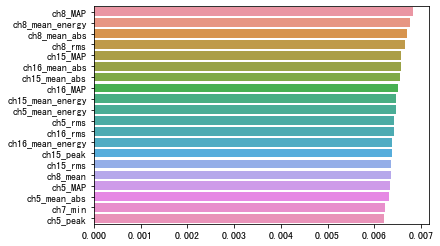

In [99]:
# fe_list[0:20]
tt = fe_list[0:20]
t1 = [item[0] for item in tt]
t2 = [np.abs(item[1]) for item in tt]

sns.barplot(x=t2, y=t1)
# ax.set_xlabel()
plt.show()

The top features are very different compare to our binary classification task.

In [100]:
# # Compare with SHAP values' results
# import shap
# # load JS visualization code to notebook 
# shap.initjs() 

# explainer = shap.TreeExplainer(best_random_rf) 

# x_test = pd.DataFrame(x_test, columns=col_name)
# shap_values = explainer.shap_values(x_test)
# shap_interaction_values = explainer.shap_interaction_values(x_test)


# print("Variable Importance Plot - Global Interpretation") 
# figure = plt.figure() 
# shap.summary_plot(shap_values, x_test)

SHAP need a lot of time and computing ability.

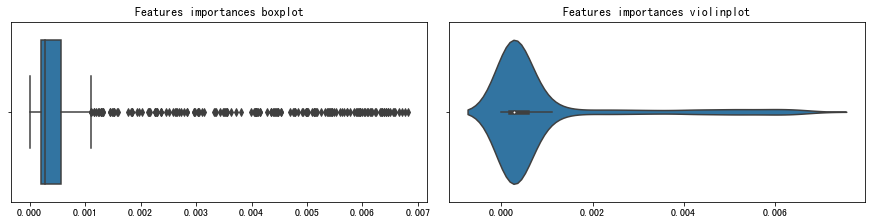

In [101]:
fe_list_value = [np.abs(item[1]) for item in fe_list]

fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(fe_list_value, ax=ax[0])
axesSub.set_title('Features importances boxplot')
axesSub = sns.violinplot(fe_list_value, ax=ax[1])
axesSub.set_title('Features importances violinplot')
plt.show()

threshold choose 0.001

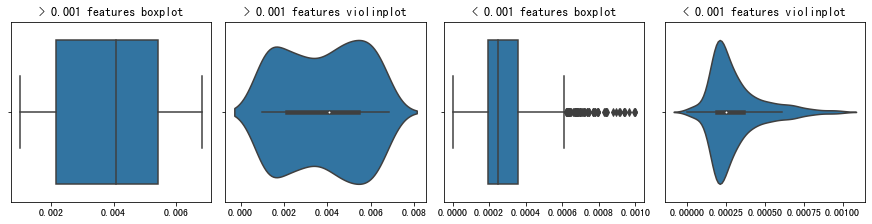

In [102]:
big, small = threshold_list(fe_list_value, threshold=0.001)

fig, ax = plt.subplots(1,4,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(big, ax=ax[0])
axesSub.set_title('> 0.001 features boxplot')
axesSub = sns.violinplot(big, ax=ax[1])
axesSub.set_title('> 0.001 features violinplot')
axesSub = sns.boxplot(small, ax=ax[2])
axesSub.set_title('< 0.001 features boxplot')
axesSub = sns.violinplot(small, ax=ax[3])
axesSub.set_title('< 0.001 features violinplot')
plt.show()

In [103]:
threshold = 0.001

RF_df_original = dict()
RF_df_original['channel'] = list()
RF_df_original['fe_names'] = list()
RF_df_original['fe_values'] = list()
RF_df_original['full_names'] = list()

for item in fe_list:
    if np.abs(item[1]) >= threshold:
        tt = item[0].split('_')
        RF_df_original['full_names'].append(item[0])
        RF_df_original['fe_names'].append( ('_').join(tt[1:])  )
        RF_df_original['channel'].append(tt[0])
        RF_df_original['fe_values'].append(item[1])
        

RF_df_original = pd.DataFrame(RF_df_original)

tt = RF_df_original[['fe_names', 'fe_values']].groupby('fe_names')
tt =tt.sum().sort_values(by=['fe_values'], ascending=False)
t1 = np.array(tt.index[:10])
t2 = np.array(tt)[:10].reshape(-1,)

pp = RF_df_original[['channel', 'fe_values']].groupby('channel')
pp = pp.sum().sort_values(by=['fe_values'], ascending=False)
p1 = np.array(pp.index[:10])
p2 = np.array(pp)[:10].reshape(10,)

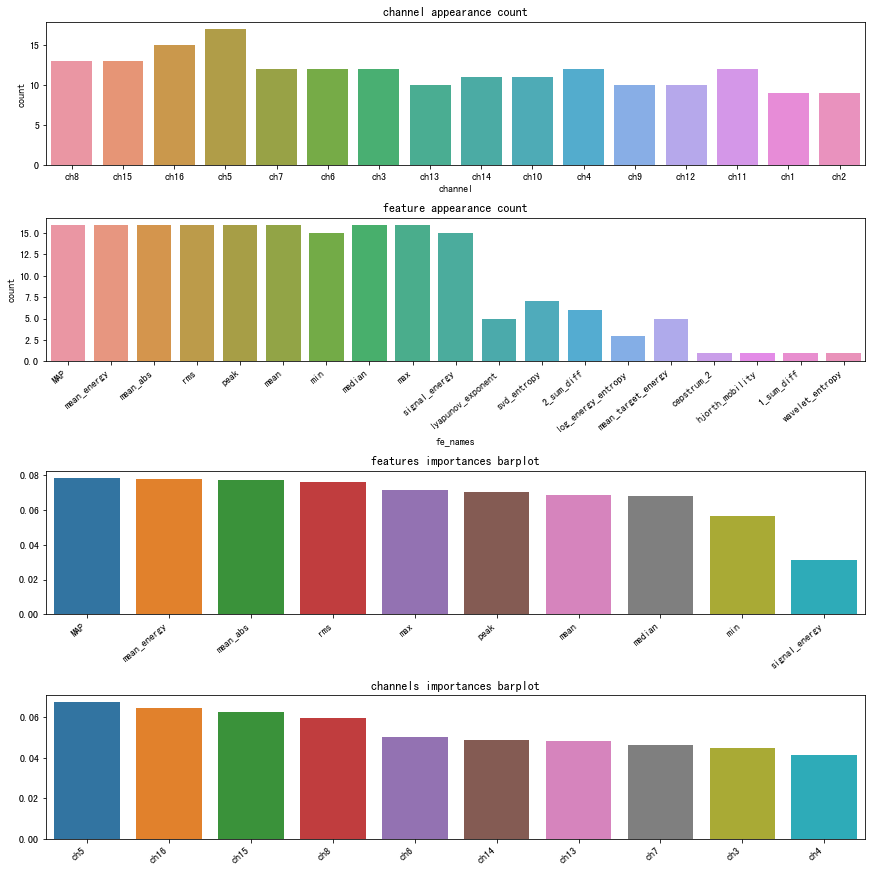

In [104]:
fig, ax = plt.subplots(4,1,constrained_layout=True, figsize=(12, 12))

#  sns.countplot(x='channel',data = LR_df_weigthed)
axesSub = sns.countplot(x='channel',data = RF_df_original,ax=ax[0])
axesSub.set_title('channel appearance count')

axesSub = sns.countplot(x='fe_names',data = RF_df_original,ax=ax[1])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('feature appearance count')

axesSub = sns.barplot(x=t1,y=t2, ax=ax[2])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('features importances barplot')

axesSub = sns.barplot(x=p1,y=p2, ax=ax[3])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('channels importances barplot')

plt.show()

Here the most important feature are MAP, mean_energy, and other statistical information.

The most important channel are 5 16 15 8.

In [106]:
pp1 = pp 

### ASL feature importance

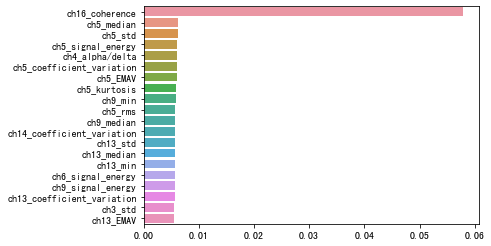

In [107]:
feat_importance_2 = best_random_rf_2.feature_importances_

fe_dict_2 = {col_name[i]:feat_importance_2[i] for i in range(len(feat_importance_2))}
fe_list_2 = sorted(fe_dict_2.items(), key=lambda x: np.abs(x[1]), reverse=True)


# fe_list[0:20]
tt = fe_list_2[0:20]
t1 = [item[0] for item in tt]
t2 = [np.abs(item[1]) for item in tt]

sns.barplot(x=t2, y=t1)
# ax.set_xlabel()
plt.show()

Feature coherence seems play a big role here!

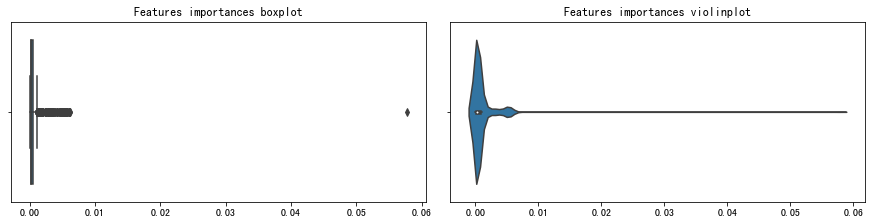

In [108]:
fe_list_value_2 = [np.abs(item[1]) for item in fe_list_2]

fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(fe_list_value_2, ax=ax[0])
axesSub.set_title('Features importances boxplot')
axesSub = sns.violinplot(fe_list_value_2, ax=ax[1])
axesSub.set_title('Features importances violinplot')
plt.show()

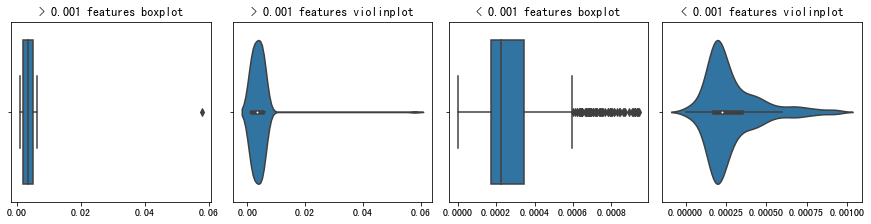

In [109]:
big, small = threshold_list(fe_list_value_2, threshold=0.001)

fig, ax = plt.subplots(1,4,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(big, ax=ax[0])
axesSub.set_title('> 0.001 features boxplot')
axesSub = sns.violinplot(big, ax=ax[1])
axesSub.set_title('> 0.001 features violinplot')
axesSub = sns.boxplot(small, ax=ax[2])
axesSub.set_title('< 0.001 features boxplot')
axesSub = sns.violinplot(small, ax=ax[3])
axesSub.set_title('< 0.001 features violinplot')
plt.show()

The feature distribution here is more uneven than the alphabet feature.

In [110]:
threshold = 0.001

RF_df_original_2 = dict()
RF_df_original_2['channel'] = list()
RF_df_original_2['fe_names'] = list()
RF_df_original_2['fe_values'] = list()
RF_df_original_2['full_names'] = list()

for item in fe_list_2:
    if np.abs(item[1]) >= threshold:
        tt = item[0].split('_')
        RF_df_original_2['full_names'].append(item[0])
        RF_df_original_2['fe_names'].append( ('_').join(tt[1:])  )
        RF_df_original_2['channel'].append(tt[0])
        RF_df_original_2['fe_values'].append(item[1])
        

RF_df_original_2 = pd.DataFrame(RF_df_original_2)

tt = RF_df_original_2[['fe_names', 'fe_values']].groupby('fe_names')
tt = tt.sum().sort_values(by=['fe_values'], ascending=False)
t1 = np.array(tt.index[:10])
t2 = np.array(tt)[:10].reshape(-1,)

pp = RF_df_original_2[['channel', 'fe_values']].groupby('channel')
pp = pp.sum().sort_values(by=['fe_values'], ascending=False)
p1 = np.array(pp.index[:10])
p2 = np.array(pp)[:10].reshape(10,)

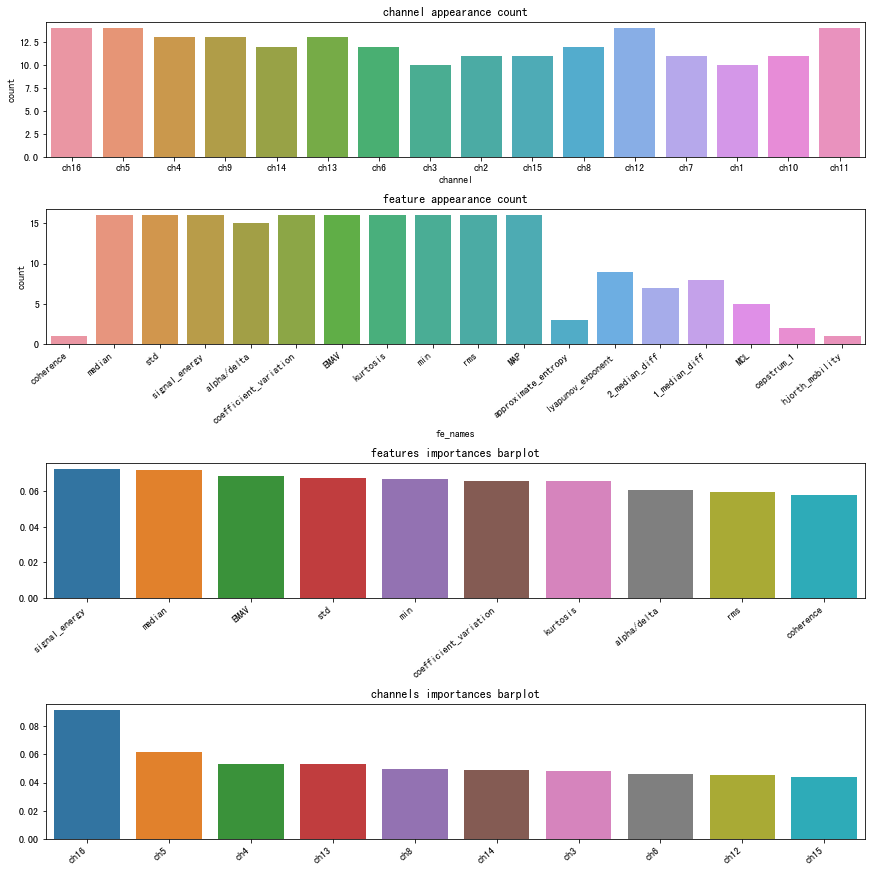

In [111]:
fig, ax = plt.subplots(4,1,constrained_layout=True, figsize=(12, 12))

#  sns.countplot(x='channel',data = LR_df_weigthed)
axesSub = sns.countplot(x='channel',data = RF_df_original_2,ax=ax[0])
axesSub.set_title('channel appearance count')

axesSub = sns.countplot(x='fe_names',data = RF_df_original_2,ax=ax[1])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('feature appearance count')

axesSub = sns.barplot(x=t1,y=t2, ax=ax[2])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('features importances barplot')

axesSub = sns.barplot(x=p1,y=p2, ax=ax[3])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('channels importances barplot')

plt.show()

Most of them are the same statistical features as before, but there are also important features in binary classification,such as coefficient_variation, kurtosis, alpha/delta, etc.


The most important channel here are 16 5 4 13; (ch5 ch 16 are also important in the last one)


(Actually, we have to distinguish the difference between sign language and alphabet. For alphabet, my brain has a memory and cognitive relationship with it, while sign language is my short-term memory, which is more inclined to image memory)

In [112]:
pp2 = pp

### Joint data feature importance

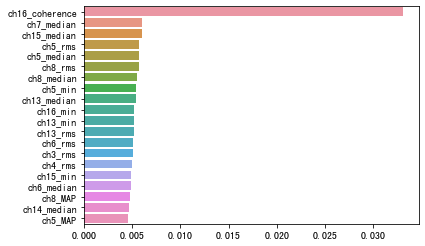

In [113]:
feat_importance_3 = best_random_rf_3.feature_importances_

fe_dict_3 = {col_name[i]:feat_importance_3[i] for i in range(len(feat_importance_3))}
fe_list_3 = sorted(fe_dict_3.items(), key=lambda x: np.abs(x[1]), reverse=True)


# fe_list[0:20]
tt = fe_list_3[0:20]
t1 = [item[0] for item in tt]
t2 = [np.abs(item[1]) for item in tt]

sns.barplot(x=t2, y=t1)
# ax.set_xlabel()
plt.show()

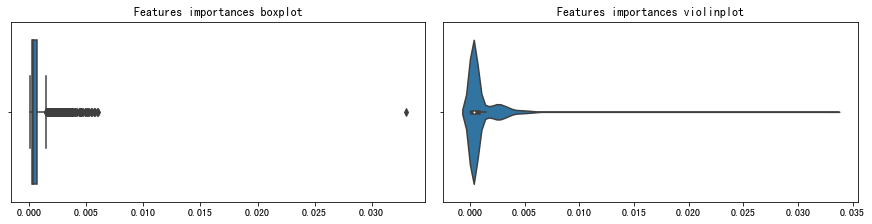

In [114]:
fe_list_value_3 = [np.abs(item[1]) for item in fe_list_3]

fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(fe_list_value_3, ax=ax[0])
axesSub.set_title('Features importances boxplot')
axesSub = sns.violinplot(fe_list_value_3, ax=ax[1])
axesSub.set_title('Features importances violinplot')
plt.show()

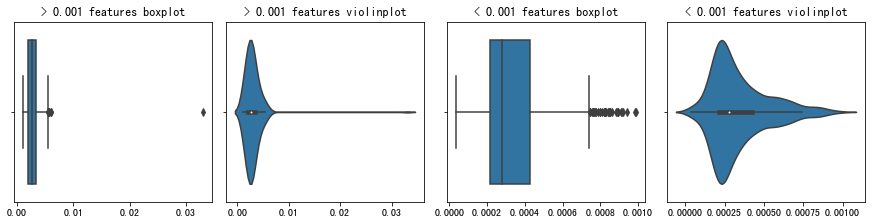

In [115]:
big, small = threshold_list(fe_list_value_3, threshold=0.001)

fig, ax = plt.subplots(1,4,constrained_layout=True, figsize=(12, 3))
axesSub = sns.boxplot(big, ax=ax[0])
axesSub.set_title('> 0.001 features boxplot')
axesSub = sns.violinplot(big, ax=ax[1])
axesSub.set_title('> 0.001 features violinplot')
axesSub = sns.boxplot(small, ax=ax[2])
axesSub.set_title('< 0.001 features boxplot')
axesSub = sns.violinplot(small, ax=ax[3])
axesSub.set_title('< 0.001 features violinplot')
plt.show()

In [116]:
threshold = 0.001

RF_df_original_3 = dict()
RF_df_original_3['channel'] = list()
RF_df_original_3['fe_names'] = list()
RF_df_original_3['fe_values'] = list()
RF_df_original_3['full_names'] = list()

for item in fe_list_3:
    if np.abs(item[1]) >= threshold:
        tt = item[0].split('_')
        RF_df_original_3['full_names'].append(item[0])
        RF_df_original_3['fe_names'].append( ('_').join(tt[1:])  )
        RF_df_original_3['channel'].append(tt[0])
        RF_df_original_3['fe_values'].append(item[1])
        

RF_df_original_3 = pd.DataFrame(RF_df_original_3)

tt = RF_df_original_3[['fe_names', 'fe_values']].groupby('fe_names')
tt = tt.sum().sort_values(by=['fe_values'], ascending=False)
t1 = np.array(tt.index[:10])
t2 = np.array(tt)[:10].reshape(-1,)

pp = RF_df_original_3[['channel', 'fe_values']].groupby('channel')
pp = pp.sum().sort_values(by=['fe_values'], ascending=False)
p1 = np.array(pp.index[:10])
p2 = np.array(pp)[:10].reshape(10,)

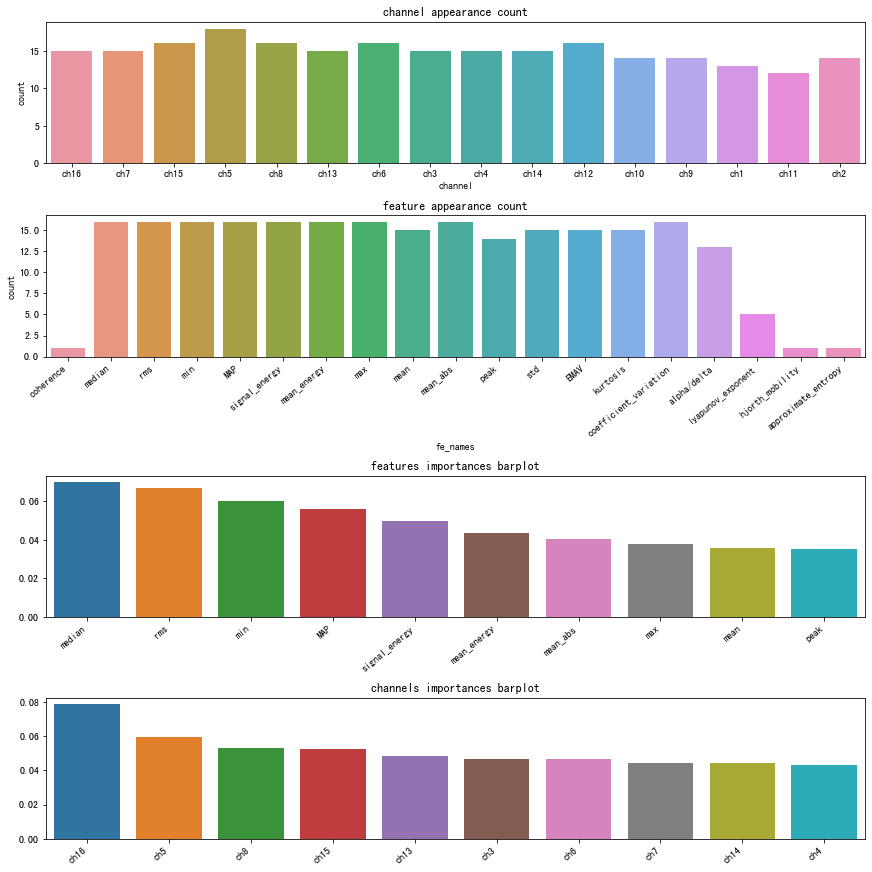

In [96]:
fig, ax = plt.subplots(4,1,constrained_layout=True, figsize=(12, 12))

#  sns.countplot(x='channel',data = LR_df_weigthed)
axesSub = sns.countplot(x='channel',data = RF_df_original_3,ax=ax[0])
axesSub.set_title('channel appearance count')

axesSub = sns.countplot(x='fe_names',data = RF_df_original_3,ax=ax[1])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('feature appearance count')

axesSub = sns.barplot(x=t1,y=t2, ax=ax[2])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('features importances barplot')

axesSub = sns.barplot(x=p1,y=p2, ax=ax[3])
axesSub.set_xticklabels(axesSub.get_xticklabels(), rotation=40, ha="right")
axesSub.set_title('channels importances barplot')

plt.show()

Because the results of this data come from the combination of sign language and alphabet, the results will be more biased towards better performance, that is, sign language, but this also shows that these statistical characteristics may be the key to determining our brain's understanding of a certain letter.

In [117]:
pp3 = pp

## Ablation experiments

We will perform ablation experiments according to the importance of the channel features in the previous part, delete some channels and corresponding features, and check the performance of the random forest on the new data.

threshold of performance will be 0.8;

Define a function to drop ch features:

In [50]:
def drop_ch_features(df,drop_list):
    
    results = list()
    fe_name = list(df.columns)
    
    for item in fe_name:
        strr = item.split('_')
        if strr[0] in drop_list:
            continue
        else:
            results.append(item)
    # print(len(results))
    return df[results],results

In [51]:
# data_all = np.concatenate((aat_img, aat_vis), axis=0) 
# data_all = pd.DataFrame(data_all, columns=col_name)
# # data_all.columns
# new_x = drop_ch_features(data_all, ['ch1','ch2'])
# new_x.shape

### Alphabet 26

In [131]:
pp1

,fe_values
channel,
ch5,0.067484
ch16,0.064723
ch15,0.062342
ch8,0.059675
ch6,0.050038
ch14,0.048942
ch13,0.048478
ch7,0.046051
ch3,0.044636


Drop ch1 ch2(less than 0.02):

In [52]:
data_all = np.concatenate((aat_img, aat_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x,fe_names = drop_ch_features(data_all, ['ch1','ch2'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_2,test_size=0.3)

rf = RandomForestClassifier(n_estimators=1493, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=44, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.8753129694541812
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.952   | 0.878  |    0.998    |    1    |
| B |   0.843   | 0.882  |    0.993    |    1    |
| C |   0.906   | 0.951  |    0.996    |    1    |
| D |   0.897   | 0.824  |    0.996    |    1    |
| E |    0.89   | 0.855  |    0.996    |    1    |
| F |   0.793   | 0.867  |    0.991    |    1    |
| G |   0.935   | 0.716  |    0.998    |    1    |
| H |   0.893   |  0.87  |    0.996    |    1    |
| I |   0.873   | 0.827  |    0.995    |    1    |
| J |   0.813   | 0.847  |    0.993    |    1    |
| K |   0.867   | 0.929  |    0.995    |    1    |
| L |   0.921   | 0.833  |    0.997    |    1    |
| M |   0.821   | 0.877  |    0.993    |    1    |
| N |    0.93   | 0.957  |    0.997    |    1    |
| O |   0.912   | 0.924  |    0.996    |    1    |
| P |   0.895   | 0.797  |    0.997    |

'0.8753129694541812'

The performance maintains.

Drop feature importance values less than 0.04 channels:

In [53]:
data_all = np.concatenate((aat_img, aat_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x, fe_names = drop_ch_features(data_all, ['ch1','ch2','ch11','ch9','ch12'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_2,test_size=0.3)

rf = RandomForestClassifier(n_estimators=1493, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=44, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.8587881822734101
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.873   | 0.841  |    0.995    |    1    |
| B |   0.875   | 0.917  |    0.994    |    1    |
| C |   0.778   | 0.864  |     0.99    |    1    |
| D |   0.918   | 0.779  |    0.997    |    1    |
| E |   0.877   |  0.78  |    0.995    |    1    |
| F |   0.866   | 0.922  |    0.994    |    1    |
| G |   0.958   | 0.775  |    0.998    |    1    |
| H |   0.928   |  0.81  |    0.997    |    1    |
| I |   0.871   | 0.884  |    0.995    |    1    |
| J |   0.844   | 0.833  |    0.994    |    1    |
| K |   0.928   | 0.842  |    0.997    |    1    |
| L |   0.871   | 0.871  |    0.994    |    1    |
| M |   0.866   | 0.806  |    0.995    |    1    |
| N |   0.904   | 0.892  |    0.996    |    1    |
| O |   0.927   |  0.81  |    0.998    |    1    |
| P |   0.886   | 0.912  |    0.996    |

'0.8587881822734101'

The performance drops a little 0.02.

Drop feature importance values less than 0.05 channels:

In [54]:
data_all = np.concatenate((aat_img, aat_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x, fe_names = drop_ch_features(data_all, ['ch1','ch2','ch3','ch4','ch7','ch9','ch10','ch11','ch12','ch13','ch14'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_2,test_size=0.3)

rf = RandomForestClassifier(n_estimators=1493, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=44, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.8527791687531296
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.862   | 0.824  |    0.995    |    1    |
| B |   0.786   |  0.93  |    0.991    |    1    |
| C |   0.868   | 0.868  |    0.995    |    1    |
| D |   0.944   | 0.931  |    0.998    |    1    |
| E |    0.93   | 0.825  |    0.997    |    1    |
| F |   0.837   | 0.951  |    0.992    |    1    |
| G |   0.899   | 0.849  |    0.996    |    1    |
| H |   0.905   | 0.859  |    0.996    |    1    |
| I |   0.901   | 0.889  |    0.996    |    1    |
| J |   0.931   | 0.848  |    0.997    |    1    |
| K |   0.888   | 0.899  |    0.995    |    1    |
| L |   0.852   | 0.862  |    0.994    |    1    |
| M |   0.944   |  0.8   |    0.998    |    1    |
| N |   0.912   | 0.859  |    0.996    |    1    |
| O |   0.805   | 0.835  |    0.992    |    1    |
| P |    0.8    | 0.771  |    0.992    |

'0.8527791687531296'

The performance drops a little 0.02.

Drop feature importance values less than 0.06 channels(three channels are kept):

In [55]:
data_all = np.concatenate((aat_img, aat_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x, fe_names = drop_ch_features(data_all, ['ch1','ch2','ch3','ch4','ch6','ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_2,test_size=0.3)

rf = RandomForestClassifier(n_estimators=1493, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=44, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.8197295943915874
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.917   | 0.835  |    0.997    |    1    |
| B |   0.803   | 0.924  |    0.992    |    1    |
| C |   0.855   | 0.843  |    0.995    |    1    |
| D |   0.823   | 0.765  |    0.993    |    1    |
| E |   0.859   | 0.813  |    0.995    |    1    |
| F |    0.76   | 0.792  |    0.991    |    1    |
| G |   0.831   | 0.831  |    0.993    |    1    |
| H |   0.901   | 0.859  |    0.996    |    1    |
| I |   0.814   | 0.826  |    0.993    |    1    |
| J |   0.882   | 0.779  |    0.996    |    1    |
| K |   0.873   | 0.861  |    0.995    |    1    |
| L |   0.909   | 0.682  |    0.997    |    1    |
| M |   0.844   | 0.774  |    0.994    |    1    |
| N |   0.819   | 0.975  |    0.991    |    1    |
| O |   0.923   | 0.759  |    0.997    |    1    |
| P |   0.812   | 0.767  |    0.993    |

'0.8197295943915874'

The performance drops 0.06.

Just keep the most important channel 5:

In [56]:
data_all = np.concatenate((aat_img, aat_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x, fe_names = drop_ch_features(data_all, ['ch1','ch2','ch3','ch4','ch6','ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch16'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_2,test_size=0.3)

rf = RandomForestClassifier(n_estimators=1493, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=44, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.642463695543315
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.658   | 0.667  |    0.987    |    1    |
| B |   0.646   | 0.545  |    0.988    |    1    |
| C |   0.688   | 0.663  |    0.987    |    1    |
| D |   0.623   | 0.642  |    0.987    |    1    |
| E |    0.6    |  0.52  |    0.986    |    1    |
| F |   0.567   | 0.708  |     0.98    |    1    |
| G |    0.6    | 0.608  |    0.984    |    1    |
| H |   0.561   | 0.536  |    0.985    |    1    |
| I |   0.636   | 0.645  |    0.985    |    1    |
| J |   0.662   | 0.662  |    0.986    |    1    |
| K |   0.634   |  0.57  |    0.986    |    1    |
| L |   0.707   | 0.662  |    0.989    |    1    |
| M |   0.683   | 0.573  |     0.99    |    1    |
| N |   0.545   | 0.646  |    0.982    |    1    |
| O |   0.667   | 0.632  |    0.988    |    1    |
| P |   0.706   | 0.686  |     0.99    | 

'0.642463695543315'

The performance drops 0.23.

Just keep the most important channel 16:

In [58]:
data_all = np.concatenate((aat_img, aat_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x,fe_names = drop_ch_features(data_all, ['ch1','ch2','ch3','ch4','ch6','ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch5'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_2,test_size=0.3)

rf = RandomForestClassifier(n_estimators=1493, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=44, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.6559839759639459
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.644   | 0.573  |    0.986    |    1    |
| B |   0.569   | 0.521  |    0.985    |    1    |
| C |   0.781   |  0.76  |    0.992    |    1    |
| D |    0.72   | 0.761  |    0.989    |    1    |
| E |   0.557   | 0.672  |    0.984    |    1    |
| F |   0.628   | 0.794  |    0.983    |    1    |
| G |   0.682   | 0.592  |    0.989    |    1    |
| H |   0.566   | 0.729  |    0.983    |    1    |
| I |   0.827   | 0.653  |    0.993    |    1    |
| J |   0.591   | 0.663  |     0.98    |    1    |
| K |   0.667   | 0.578  |    0.987    |    1    |
| L |   0.634   | 0.584  |    0.986    |    1    |
| M |    0.61   | 0.474  |    0.988    |    1    |
| N |    0.61   | 0.662  |    0.984    |    1    |
| O |   0.727   | 0.651  |    0.989    |    1    |
| P |   0.734   | 0.701  |    0.991    |

'0.6559839759639459'

Keep the most unimportant ch1 ch2:

In [59]:
data_all = np.concatenate((aat_img, aat_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x,fe_names = drop_ch_features(data_all, ['ch5','ch3','ch4','ch6','ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch16'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_2,test_size=0.3)

rf = RandomForestClassifier(n_estimators=1493, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=44, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.5247871807711567
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.642   | 0.538  |    0.987    |    1    |
| B |   0.432   | 0.443  |    0.976    |    0    |
| C |    0.56   | 0.488  |    0.983    |    1    |
| D |   0.438   | 0.457  |    0.979    |    0    |
| E |    0.55   | 0.423  |    0.986    |    0    |
| F |   0.526   | 0.621  |    0.981    |    1    |
| G |   0.526   | 0.488  |    0.981    |    1    |
| H |   0.561   | 0.468  |    0.985    |    1    |
| I |   0.597   | 0.613  |    0.984    |    1    |
| J |   0.633   | 0.427  |    0.988    |    1    |
| K |   0.617   | 0.446  |    0.988    |    1    |
| L |   0.461   | 0.479  |    0.979    |    0    |
| M |   0.543   | 0.481  |    0.983    |    1    |
| N |   0.526   | 0.519  |    0.981    |    1    |
| O |   0.493   | 0.515  |    0.981    |    1    |
| P |   0.412   | 0.444  |    0.979    |

'0.5247871807711567'

As we delete more and more channels, the performance of the model will continue to decline, and the effect of retaining only three important channels is about 81%.

And remember one thing, check the notebook plot comparison! We will understand why those channels are more important!

### ASL

In [136]:
pp2

,fe_values
channel,
ch16,0.091393
ch5,0.061721
ch4,0.053509
ch13,0.053396
ch8,0.049599
ch14,0.048902
ch3,0.048484
ch6,0.045906
ch12,0.045163


Drop feature importance values less than 0.04 channels:

In [60]:
data_all = np.concatenate((asl_img, asl_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x, fe_names = drop_ch_features(data_all, ['ch1','ch2','ch10','ch11'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_2,test_size=0.3)

rf = RandomForestClassifier(n_estimators= 386, min_samples_split=4, min_samples_leaf=2, 
                            max_features='auto', max_depth=78, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.9203805708562844
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.929   | 0.975  |    0.997    |    1    |
| B |   0.962   | 0.885  |    0.998    |    1    |
| C |   0.936   | 0.961  |    0.997    |    1    |
| D |   0.959   | 0.798  |    0.998    |    1    |
| E |    0.88   | 0.924  |    0.995    |    1    |
| F |   0.932   |  0.92  |    0.997    |    1    |
| G |   0.923   | 0.923  |    0.997    |    1    |
| H |   0.939   | 0.917  |    0.997    |    1    |
| I |   0.894   | 0.894  |    0.995    |    1    |
| J |   0.921   | 0.959  |    0.997    |    1    |
| K |   0.909   | 0.897  |    0.996    |    1    |
| L |   0.944   | 0.829  |    0.998    |    1    |
| M |   0.897   | 0.847  |    0.996    |    1    |
| N |   0.895   | 0.958  |    0.996    |    1    |
| O |   0.938   | 0.759  |    0.998    |    1    |
| P |   0.888   |  1.0   |    0.995    |

'0.9203805708562844'

The performance has improved 0.02.

Drop feature importance values less than 0.05 channels:

In [61]:
data_all = np.concatenate((asl_img, asl_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x, fe_names = drop_ch_features(data_all, ['ch1','ch2','ch3','ch6','ch7','ch8','ch9','ch10','ch11','ch12','ch14','ch15'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_2,test_size=0.3)

rf = RandomForestClassifier(n_estimators= 386, min_samples_split=4, min_samples_leaf=2, 
                            max_features='auto', max_depth=78, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.9183775663495243
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.984   |  1.0   |    0.999    |    1    |
| B |   0.987   |  1.0   |    0.999    |    1    |
| C |   0.974   | 0.987  |    0.999    |    1    |
| D |   0.969   | 0.969  |    0.999    |    1    |
| E |   0.958   |  0.84  |    0.998    |    1    |
| F |   0.977   | 0.933  |    0.999    |    1    |
| G |   0.903   | 0.942  |    0.996    |    1    |
| H |    0.89   | 0.936  |    0.995    |    1    |
| I |   0.938   | 0.923  |    0.998    |    1    |
| J |   0.845   | 0.845  |    0.994    |    1    |
| K |    0.87   | 0.798  |    0.995    |    1    |
| L |   0.893   | 0.843  |    0.995    |    1    |
| M |   0.819   | 0.932  |    0.992    |    1    |
| N |   0.928   | 0.889  |    0.997    |    1    |
| O |   0.877   | 0.792  |    0.996    |    1    |
| P |   0.882   | 0.893  |    0.995    |

'0.9183775663495243'

The performance has improved 0.01(compare with all channels).

Drop feature importance values less than 0.06 channels(just keep two channels):

In [62]:
data_all = np.concatenate((asl_img, asl_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x, fe_names = drop_ch_features(data_all, ['ch1','ch2','ch3','ch4','ch6','ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_2,test_size=0.3)

rf = RandomForestClassifier(n_estimators= 386, min_samples_split=4, min_samples_leaf=2, 
                            max_features='auto', max_depth=78, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.929394091136705
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.987   | 0.949  |    0.999    |    1    |
| B |   0.974   |  1.0   |    0.999    |    1    |
| C |   0.962   | 0.974  |    0.998    |    1    |
| D |   0.907   | 0.971  |    0.996    |    1    |
| E |   0.877   | 0.947  |    0.995    |    1    |
| F |   0.914   | 0.851  |    0.996    |    1    |
| G |   0.868   | 0.952  |    0.995    |    1    |
| H |   0.924   | 0.968  |    0.997    |    1    |
| I |   0.947   | 0.888  |    0.998    |    1    |
| J |   0.903   | 0.833  |    0.996    |    1    |
| K |   0.974   | 0.826  |    0.999    |    1    |
| L |   0.907   | 0.895  |    0.996    |    1    |
| M |   0.821   | 0.908  |    0.992    |    1    |
| N |   0.918   |  0.87  |    0.997    |    1    |
| O |   0.904   | 0.915  |    0.996    |    1    |
| P |   0.959   | 0.845  |    0.998    | 

'0.929394091136705'

The performance has improved 0.03(compared with all channels).

For the following code part:

Still drop feature importance values less than 0.06 channels:

(Because of the problem with the previous code, in fact, the feature is not deleted, but copied, but the unexpected result is very good, so I still keep this wrong code but the perfect following result.)

In [144]:
data_all = np.concatenate((asl_img, asl_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x = drop_ch_features(data_all, ['ch1','ch2','ch3','ch4','ch6','ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_2,test_size=0.3)

rf = RandomForestClassifier(n_estimators= 386, min_samples_split=4, min_samples_leaf=2, 
                            max_features='auto', max_depth=78, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.9744616925388082
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |    1.0    |  1.0   |     1.0     |    1    |
| B |    1.0    |  1.0   |     1.0     |    1    |
| C |   0.976   | 0.988  |    0.999    |    1    |
| D |   0.984   | 0.954  |    0.999    |    1    |
| E |    1.0    | 0.985  |     1.0     |    1    |
| F |   0.975   | 0.975  |    0.999    |    1    |
| G |    1.0    |  1.0   |     1.0     |    1    |
| H |   0.964   | 0.976  |    0.998    |    1    |
| I |   0.976   | 0.964  |    0.999    |    1    |
| J |   0.958   | 0.958  |    0.998    |    1    |
| K |   0.972   | 0.958  |    0.999    |    1    |
| L |    0.91   |  1.0   |    0.996    |    1    |
| M |   0.987   | 0.925  |    0.999    |    1    |
| N |   0.934   |  1.0   |    0.997    |    1    |
| O |   0.966   | 0.988  |    0.998    |    1    |
| P |   0.972   | 0.945  |    0.999    |

'0.9744616925388082'

Just keep the most important channel 5:

In [63]:
data_all = np.concatenate((asl_img, asl_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x, fe_names = drop_ch_features(data_all, ['ch1','ch2','ch3','ch4','ch6','ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch16'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_2,test_size=0.3)

rf = RandomForestClassifier(n_estimators= 386, min_samples_split=4, min_samples_leaf=2, 
                            max_features='auto', max_depth=78, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.6670005007511267
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.646   | 0.726  |    0.985    |    1    |
| B |   0.711   | 0.771  |    0.989    |    1    |
| C |   0.726   |  0.57  |    0.991    |    1    |
| D |   0.662   | 0.614  |    0.989    |    1    |
| E |   0.606   | 0.563  |    0.987    |    1    |
| F |   0.761   | 0.739  |    0.992    |    1    |
| G |   0.623   | 0.672  |    0.987    |    1    |
| H |   0.696   | 0.506  |    0.991    |    1    |
| I |   0.688   |  0.62  |     0.99    |    1    |
| J |   0.635   |  0.61  |    0.986    |    1    |
| K |   0.633   | 0.514  |    0.989    |    1    |
| L |   0.586   | 0.654  |    0.981    |    1    |
| M |   0.822   | 0.682  |    0.993    |    1    |
| N |   0.759   | 0.716  |     0.99    |    1    |
| O |   0.587   | 0.638  |    0.984    |    1    |
| P |   0.644   | 0.682  |    0.983    |

'0.6670005007511267'

As we delete more and more channels, the performance of the model will continue to decline, and the effect of retaining only two important channels is about 92%.


The results seem a little strange, here. In the beginning, after deleting some features, the performance of our model has improved a bit. 


But in fact, this is very normal. We can find that in the process of sign language experiment, there is a wrong result (I failed to delete the feature, but copied and added the feature), but the accuracy rate actually reached 97%. Because the performance of our model has not reached the theoretical maximum value, due to the limitation of time and computing resources, although the performance seems to have improved by 0.01-0.02 in the first two experiments, it is actually lower than the ideal 0.97.

### Joint data

In [146]:
pp3

,fe_values
channel,
ch16,0.078752
ch5,0.059342
ch8,0.053368
ch15,0.052449
ch13,0.048670
ch3,0.046779
ch6,0.046674
ch7,0.044566
ch14,0.044131


Drop feature importance values less than 0.04 channels:

In [64]:
data_all = np.concatenate((asl_img, asl_vis, aat_img, aat_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x,fe_names = drop_ch_features(data_all, ['ch1','ch2','ch9','ch10','ch11'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_4,test_size=0.3)

rf = RandomForestClassifier(n_estimators= 529, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=34, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.8833249874812218
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |    0.93   | 0.943  |    0.997    |    1    |
| B |   0.894   | 0.899  |    0.996    |    1    |
| C |   0.876   | 0.827  |    0.994    |    1    |
| D |   0.943   | 0.846  |    0.998    |    1    |
| E |   0.924   | 0.813  |    0.997    |    1    |
| F |   0.839   | 0.907  |    0.993    |    1    |
| G |   0.858   | 0.784  |    0.995    |    1    |
| H |   0.921   | 0.902  |    0.997    |    1    |
| I |   0.882   |  0.92  |    0.996    |    1    |
| J |   0.864   | 0.853  |    0.995    |    1    |
| K |   0.903   | 0.867  |    0.996    |    1    |
| L |   0.839   | 0.922  |    0.994    |    1    |
| M |   0.827   | 0.892  |    0.993    |    1    |
| N |   0.898   | 0.916  |    0.996    |    1    |
| O |   0.964   | 0.831  |    0.999    |    1    |
| P |   0.905   | 0.867  |    0.997    |

'0.8833249874812218'

The performance maintains(compare with all channels).

Drop feature importance values less than 0.05 channels:

In [65]:
data_all = np.concatenate((asl_img, asl_vis, aat_img, aat_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x, fe_names = drop_ch_features(data_all, ['ch1','ch2','ch3','ch4','ch6','ch7','ch9','ch10','ch11','ch12','ch13','ch14'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_4,test_size=0.3)

rf = RandomForestClassifier(n_estimators= 529, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=34, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.8660490736104156
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.911   | 0.869  |    0.997    |    1    |
| B |   0.888   | 0.916  |    0.995    |    1    |
| C |   0.881   | 0.934  |    0.995    |    1    |
| D |   0.823   | 0.839  |    0.993    |    1    |
| E |   0.839   | 0.815  |    0.993    |    1    |
| F |   0.793   | 0.899  |    0.991    |    1    |
| G |   0.862   | 0.801  |    0.995    |    1    |
| H |    0.9    | 0.877  |    0.996    |    1    |
| I |   0.872   | 0.826  |    0.995    |    1    |
| J |   0.831   | 0.864  |    0.993    |    1    |
| K |   0.836   | 0.775  |    0.994    |    1    |
| L |    0.9    | 0.931  |    0.996    |    1    |
| M |    0.91   | 0.876  |    0.996    |    1    |
| N |   0.911   | 0.875  |    0.997    |    1    |
| O |   0.926   | 0.846  |    0.997    |    1    |
| P |   0.806   | 0.778  |    0.993    |

'0.8660490736104156'

The performance drops 0.02(compare with all channels).

Keep the channel 5 and 16:

In [66]:
data_all = np.concatenate((asl_img, asl_vis, aat_img, aat_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x, fitenames = drop_ch_features(data_all, ['ch1','ch2','ch3','ch4','ch6','ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_4,test_size=0.3)

rf = RandomForestClassifier(n_estimators= 529, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=34, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.8555332999499249
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.953   | 0.904  |    0.998    |    1    |
| B |   0.863   | 0.885  |    0.994    |    1    |
| C |    0.85   | 0.855  |    0.993    |    1    |
| D |    0.86   | 0.826  |    0.995    |    1    |
| E |   0.792   | 0.758  |    0.992    |    1    |
| F |    0.86   | 0.842  |    0.995    |    1    |
| G |   0.857   | 0.795  |    0.994    |    1    |
| H |   0.858   | 0.809  |    0.995    |    1    |
| I |   0.872   | 0.883  |    0.995    |    1    |
| J |   0.878   |  0.83  |    0.996    |    1    |
| K |   0.826   | 0.853  |    0.993    |    1    |
| L |   0.839   |  0.76  |    0.993    |    1    |
| M |   0.778   | 0.872  |    0.991    |    1    |
| N |   0.841   | 0.812  |    0.993    |    1    |
| O |   0.876   | 0.828  |    0.996    |    1    |
| P |   0.849   | 0.849  |    0.994    |

'0.8555332999499249'

The performance drops 0.03(compare with all channels).

Like ASL, a wrong code but perfect results:

In [149]:
data_all = np.concatenate((asl_img, asl_vis, aat_img, aat_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x = drop_ch_features(data_all, ['ch1','ch2','ch3','ch4','ch6','ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_4,test_size=0.3)

rf = RandomForestClassifier(n_estimators= 529, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=34, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.9076114171256885
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.934   | 0.877  |    0.998    |    1    |
| B |   0.886   | 0.899  |    0.996    |    1    |
| C |   0.919   | 0.893  |    0.996    |    1    |
| D |   0.902   | 0.847  |    0.996    |    1    |
| E |   0.933   | 0.869  |    0.997    |    1    |
| F |   0.902   | 0.932  |    0.995    |    1    |
| G |   0.914   | 0.931  |    0.996    |    1    |
| H |   0.881   | 0.952  |    0.995    |    1    |
| I |   0.949   |  0.91  |    0.998    |    1    |
| J |   0.924   | 0.865  |    0.997    |    1    |
| K |   0.856   | 0.881  |    0.995    |    1    |
| L |   0.912   | 0.896  |    0.996    |    1    |
| M |   0.883   | 0.905  |    0.995    |    1    |
| N |   0.912   | 0.918  |    0.996    |    1    |
| O |   0.936   |  0.91  |    0.998    |    1    |
| P |   0.898   | 0.898  |    0.996    |

'0.9076114171256885'

Just keep the channel 16:

In [67]:
data_all = np.concatenate((asl_img, asl_vis, aat_img, aat_vis), axis=0) 
data_all = pd.DataFrame(data_all, columns=col_name)
new_x, fe_names = drop_ch_features(data_all, ['ch1','ch2','ch3','ch4','ch6','ch7','ch8','ch9','ch10','ch11','ch12','ch13','ch14','ch15','ch5'])
x_train,x_test,y_train,y_test = train_test_split(new_x,labels_4,test_size=0.3)

rf = RandomForestClassifier(n_estimators= 529, min_samples_split=2, min_samples_leaf=2, 
                            max_features='auto', max_depth=34, bootstrap=False)
rf.fit(x_train, y_train)

confusion = ConfusionMatrix(num_classes=26, labels=['A','B','C','D','E','F','G','H','I','J','K','L',
                                                    'M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z'])
confusion.update(rf.predict(x_test), y_test)
confusion.summary()

the model accuracy is  0.7656484727090636
+---+-----------+--------+-------------+---------+
|   | Precision | Recall | Specificity | F1score |
+---+-----------+--------+-------------+---------+
| A |   0.849   | 0.738  |    0.995    |    1    |
| B |   0.802   | 0.769  |    0.992    |    1    |
| C |   0.793   | 0.747  |    0.991    |    1    |
| D |   0.797   | 0.679  |    0.993    |    1    |
| E |   0.725   | 0.688  |    0.989    |    1    |
| F |   0.752   | 0.767  |     0.99    |    1    |
| G |   0.682   | 0.719  |    0.987    |    1    |
| H |   0.619   | 0.699  |    0.986    |    1    |
| I |   0.884   | 0.793  |    0.996    |    1    |
| J |   0.737   | 0.782  |    0.989    |    1    |
| K |   0.687   | 0.742  |    0.987    |    1    |
| L |   0.718   | 0.755  |    0.988    |    1    |
| M |    0.72   | 0.796  |    0.988    |    1    |
| N |   0.772   | 0.687  |    0.991    |    1    |
| O |   0.671   | 0.818  |    0.986    |    1    |
| P |   0.796   |  0.75  |    0.992    |

'0.7656484727090636'

As we delete more and more channels, the performance of the model will continue to decline, and the effect of retaining only two important channels is about 85%. (between ASL and alphabet)

If just keep one channel, all joint data has a good score 76% compared with the others!

Still, a wrong code has the best ACC 90%.


So far, our machine learning part is completely completed. In the next notebook, we will test some deep learning models and compare the effects of the two methods(DL vs ML).

In the 26 classification task, the most important features are statistical features, and the most important channels are 5 and 16.